### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from releaser import Releaser, mini_releaser
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
# model_path = base_path + "model_runs/elife_resub_dist/"
# load_name = "dist_quanta_60rep_6s_12t_x2w_12kv"
# rev_name = "dist_quanta_60rep_6t_12s_x2w_12kv"
# model_path = base_path + "model_runs/elife_resub_dist_redo/"
# load_name = "dist_quanta_60rep_6s_12t_x2p7_frac6"
# rev_name = "dist_quanta_60rep_6t_12s_x2p7_frac6"
# model_path = base_path + "model_runs/elife_resub_dist_redo_kvgrad/"
# load_name = "dist_quanta_60rep_6s_12t_x2p7_frac6_kvgrad"
# rev_name = "dist_quanta_60rep_6t_12s_x2p7_frac6_kvgrad"
model_path = base_path + "model_runs/elife_resub_dist_redo_kvgrad_x2p5/"
load_name = "dist_quanta_60rep_6s_12t_x2p5_frac6_kvgrad"
rev_name = "dist_quanta_60rep_6t_12s_x2p5_frac6_kvgrad"
# model_path = base_path + "model_runs/elife_resub_dist_redo_kvgrad_cap/"
# load_name = "dist_quanta_60rep_6s_12t_x2p5_frac6_kvgrad_cap"
# rev_name = "dist_quanta_60rep_6t_12s_x2p5_frac6_kvgrad_cap"

In [4]:
with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
    data = {
        int(rep): {
            cond: {
                sac: {
                    metric : f[rep][cond]["data"]["term"][sac][metric][:]
                    for metric in f[rep][cond]["data"]["term"][sac].keys()
                }
                for sac in f[rep][cond]["data"]["term"].keys()
            }
            for cond in f[rep].keys()
        }
        for rep in f.keys()
    }
    first_cond = list(data[0].keys())[0]
    bp_locs = {"sust": [], "trans": []}
    for rep in f.keys():
        params = json.loads(f[rep][first_cond]["model_params"][()])
        bp_locs["sust"].append(params["a"]["bp_locs"]["sust"])
        bp_locs["trans"].append(params["a"]["bp_locs"]["trans"])
    bp_locs = {k: np.array(v) for k, v in bp_locs.items()}
                            
    model_params = json.loads(f["0"][first_cond]["model_params"][()])
    exp_params = json.loads(f["0"][first_cond]["exp_params"][()])
    
if rev_name is not None:
    with h5.File(os.path.join(model_path, rev_name + ".h5"), "r") as f:
        rev = {
            int(rep): {
                cond: {
                    sac: {
                        metric : f[rep][cond]["data"]["term"][sac][metric][:]
                        for metric in f[rep][cond]["data"]["term"][sac].keys()
                    }
                    for sac in f[rep][cond]["data"]["term"].keys()
                }
                for cond in f[rep].keys()
            }
            for rep in f.keys()
        }
        rev_bp_locs = {"sust": [], "trans": []}
        for rep in f.keys():
            params = json.loads(f[rep][first_cond]["model_params"][()])
            rev_bp_locs["sust"].append(params["a"]["bp_locs"]["sust"])
            rev_bp_locs["trans"].append(params["a"]["bp_locs"]["trans"])
        rev_bp_locs = {k: np.array(v) for k, v in rev_bp_locs.items()}
    
dt = exp_params["dt"]
rec_xaxis = np.arange(0, exp_params["tstop"] + dt, dt)
velocities = exp_params["velocities"]
rec_shape = data[0][first_cond]["a"]["cai"].shape
n_trials = len(data.keys())
print("dt = %.2f ms" % dt)
print("recording shape =", rec_shape)

dt = 1.00 ms
recording shape = (1, 10, 6001)


In [5]:
ding_soma_dist_bins = np.arange(0, 170, 10)
# bin_size = ding_soma_dist[1] - ding_soma_dist[0]  # shift over so points are ends of bins
# shifted_dist = np.concatenate([[0], bin_size + ding_soma_dist])
coverage = {
    "sust": np.array([4, 15, 32, 17, 14, 11, 2, 6, 5, 4, 4, 3, 1, 0, 0, 0]),
    "trans": np.array([0, 5, 10, 7, 13, 11, 12, 6, 23, 19, 10, 8, 5, 4, 1, 1])
}
concat_coverage = np.concatenate([coverage["sust"], coverage["trans"]])
sample_hist = lambda sample: np.histogram(sample, ding_soma_dist_bins)[0]

In [6]:
bp_hists = {
    bp: np.array([sample_hist(trial) for trial in locs]) 
    for bp, locs in bp_locs.items()
}
bp_entropy = {
    bp: np.array([stats.entropy(trial, coverage[bp], base=2) for trial in hist]) 
    for bp, hist in bp_hists.items()
}
concat_entropy = np.array([
    stats.entropy(np.concatenate([s, t]), concat_coverage, base=2)
    for s, t in zip(bp_hists["sust"], bp_hists["trans"])
])
avg_entropy = (bp_entropy["sust"] + bp_entropy["trans"]) / 2

bp_mutual = {
    bp: np.array([metrics.mutual_info_score(trial, coverage[bp]) for trial in hist]) 
    for bp, hist in bp_hists.items()
}
concat_mutual = np.array([
    metrics.mutual_info_score(np.concatenate([s, t]), concat_coverage)
    for s, t in zip(bp_hists["sust"], bp_hists["trans"])
])
avg_mutual = (bp_mutual["sust"] + bp_mutual["trans"]) / 2

bp_means = {
    bp: np.mean(locs, axis=1)
    for bp, locs in bp_locs.items()
}
bp_medians = {
    bp: np.median(locs, axis=1)
    for bp, locs in bp_locs.items()
}

In [7]:
rev_bp_hists = {
    bp: np.array([sample_hist(trial) for trial in locs]) 
    for bp, locs in rev_bp_locs.items()
}
rev_bp_entropy = {
    bp: np.array([stats.entropy(trial, coverage[bp], base=2) for trial in hist]) 
    for bp, hist in rev_bp_hists.items()
}
rev_concat_entropy = np.array([
    stats.entropy(np.concatenate([s, t]), concat_coverage, base=2)
    for s, t in zip(rev_bp_hists["sust"], rev_bp_hists["trans"])
])
rev_avg_entropy = (rev_bp_entropy["sust"] + rev_bp_entropy["trans"]) / 2

rev_bp_mutual = {
    bp: np.array([metrics.mutual_info_score(trial, coverage[bp]) for trial in hist]) 
    for bp, hist in rev_bp_hists.items()
}
rev_concat_mutual = np.array([
    metrics.mutual_info_score(np.concatenate([s, t]), concat_coverage)
    for s, t in zip(rev_bp_hists["sust"], rev_bp_hists["trans"])
])
rev_avg_mutual = (rev_bp_mutual["sust"] + rev_bp_mutual["trans"]) / 2

rev_bp_means = {
    bp: np.mean(locs, axis=1)
    for bp, locs in rev_bp_locs.items()
}
rev_bp_medians = {
    bp: np.median(locs, axis=1)
    for bp, locs in rev_bp_locs.items()
}

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [8]:
thresh = -40
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["a"]["v"]),
                peak_vm_deflection(exp["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["a"]["v"], thresh),
                thresholded_area(exp["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["a"]["ica"] * -1, axis=-1),
                np.sum(exp["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["a"]["cai"], axis=-1),
                np.max(exp["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in data.items()
}

if rev_name is not None:
    for i in rev.keys():
        dsis[i]["no_gaba_rev"] = {
            "peak": pn_dsi(
                peak_vm_deflection(rev[i]["no_gaba"]["a"]["v"]),
                peak_vm_deflection(rev[i]["no_gaba"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(rev[i]["no_gaba"]["a"]["v"], thresh),
                thresholded_area(rev[i]["no_gaba"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(rev[i]["no_gaba"]["a"]["ica"] * -1, axis=-1),
                np.sum(rev[i]["no_gaba"]["b"]["ica"] * -1, axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(rev[i]["no_gaba"]["a"]["cai"], axis=-1),
                np.max(rev[i]["no_gaba"]["b"]["cai"], axis=-1)
            ),
        }

dsis = {
    cond: {
        metric: np.concatenate([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

In [9]:
print("dsi metric shape =", dsis[first_cond]["peak_[Ca]"].shape)

dsi metric shape = (60, 10)


<IPython.core.display.Javascript object>


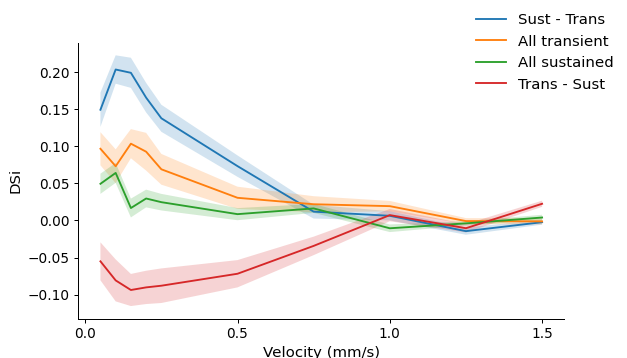

In [10]:
st_no_gaba_mean = np.mean(dsis["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_std = np.std(dsis["no_gaba"]["peak_[Ca]"], axis=0)
st_no_gaba_ste = st_no_gaba_std / np.sqrt(dsis["no_gaba"]["peak_[Ca]"].shape[0])
no_gaba_trans_mean = np.mean(dsis["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_std = np.std(dsis["no_gaba_trans"]["peak_[Ca]"], axis=0)
no_gaba_trans_ste = no_gaba_trans_std / np.sqrt(dsis["no_gaba_trans"]["peak_[Ca]"].shape[0])
no_gaba_sust_mean = np.mean(dsis["no_gaba_sust"]["peak_[Ca]"], axis=0)
no_gaba_sust_std = np.std(dsis["no_gaba_sust"]["peak_[Ca]"], axis=0)
no_gaba_sust_ste = no_gaba_sust_std / np.sqrt(dsis["no_gaba_sust"]["peak_[Ca]"].shape[0])

peak_ca_fig, peak_ca_ax = plt.subplots(1, figsize=(7, 4))
peak_ca_ax.fill_between(
    velocities, st_no_gaba_mean + st_no_gaba_ste, st_no_gaba_mean - st_no_gaba_ste, alpha=0.2)
peak_ca_ax.plot(velocities, st_no_gaba_mean, label="Sust - Trans")
peak_ca_ax.fill_between(
    velocities, no_gaba_trans_mean + no_gaba_trans_ste, no_gaba_trans_mean - no_gaba_trans_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_trans_mean, label="All transient")
peak_ca_ax.fill_between(
    velocities, no_gaba_sust_mean + no_gaba_sust_ste, no_gaba_sust_mean - no_gaba_sust_ste, alpha=0.2)
peak_ca_ax.plot(velocities, no_gaba_sust_mean, label="All sustained")

if rev_name is not None:
    ts_no_gaba_mean = np.mean(dsis["no_gaba_rev"]["peak_[Ca]"], axis=0)
    ts_no_gaba_std = np.std(dsis["no_gaba_rev"]["peak_[Ca]"], axis=0)
    ts_no_gaba_ste = ts_no_gaba_std / np.sqrt(dsis["no_gaba_rev"]["peak_[Ca]"].shape[0])
    peak_ca_ax.fill_between(
        velocities, ts_no_gaba_mean + ts_no_gaba_ste, ts_no_gaba_mean - ts_no_gaba_ste, alpha=0.2)
    peak_ca_ax.plot(velocities, ts_no_gaba_mean, label="Trans - Sust")

peak_ca_ax.set_ylabel("DSi", fontsize=12)
peak_ca_ax.set_xlabel("Velocity (mm/s)", fontsize=12)
peak_ca_ax.set_xticks([0., 0.5, 1., 1.5])
# peak_ca_ax.set_yticks([0., 0.15, 0.3])
clean_axes(peak_ca_ax)
peak_ca_fig.legend(fontsize=12, frameon=False)
peak_ca_fig.show()

for ext in [".svg", ".png"]:
    peak_ca_fig.savefig(
        os.path.join(model_path, "velocity_falloff" + ext), bbox_inches="tight")

<IPython.core.display.Javascript object>


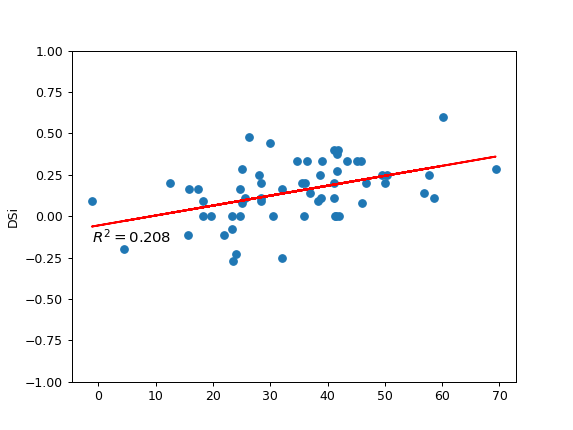

R-squared: 0.208089


Text(0, 0.5, 'DSi')

In [11]:
vel_idx = 0
ff, aa = plt.subplots(1)
# x = avg_entropy
# x = concat_entropy
# x = concat_mutual
# x = bp_medians["trans"] - bp_medians["sust"]
x = bp_means["trans"] - bp_means["sust"]
# x = bp_means["trans"]
# x = bp_means["sust"]
y = dsis["no_gaba"]["peak_[Ca]"][:, vel_idx]
res = stats.linregress(x, y) 
print(f"R-squared: {res.rvalue ** 2:.6f}")
aa.scatter(x, y)
aa.plot(x, res.intercept + res.slope*x, c="r")
aa.text(
    np.min(x), res.intercept + res.slope*np.min(x) - 0.1,
    "$R^2 = %.3f$" % (res.rvalue ** 2), 
    fontdict={"fontsize": 12},
)
# aa.set_ylim(-0.5, 1)
aa.set_ylim(-1, 1)
aa.set_ylabel("DSi")
# aa.set_xlim(0, 1)

<IPython.core.display.Javascript object>


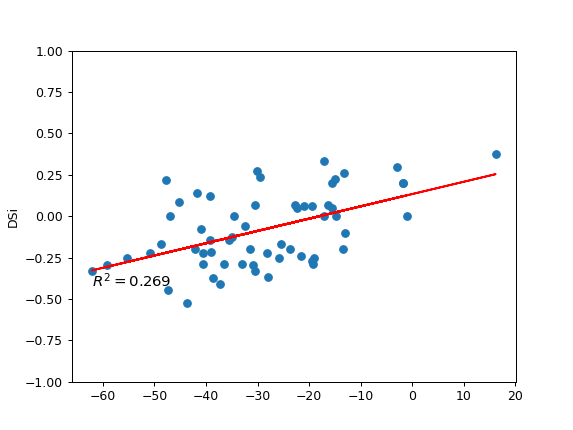

R-squared: 0.269086


Text(0, 0.5, 'DSi')

In [12]:
rev_vel_idx = 1
fff, aaa = plt.subplots(1)
# x = rev_avg_entropy
# x = rev_concat_entropy
# x = rev_concat_mutual
# x = rev_bp_medians["trans"] - rev_bp_medians["sust"]
x = rev_bp_means["trans"] - rev_bp_means["sust"]
# x = rev_bp_means["trans"]
# x = rev_bp_means["sust"]
y = dsis["no_gaba_rev"]["peak_[Ca]"][:, rev_vel_idx]
res = stats.linregress(x, y) 
print(f"R-squared: {res.rvalue ** 2:.6f}")
aaa.scatter(x, y)
aaa.plot(x, res.intercept + res.slope*x, c="r")
aaa.text(
    np.min(x), res.intercept + res.slope*np.min(x) - 0.1,
    "$R^2 = %.3f$" % (res.rvalue ** 2), 
    fontdict={"fontsize": 12},
)
# aaa.set_ylim(-1., 0.5)
aaa.set_ylim(-1., 1.)
aaa.set_ylabel("DSi")
# aa.set_xlim(0, 1)

<IPython.core.display.Javascript object>


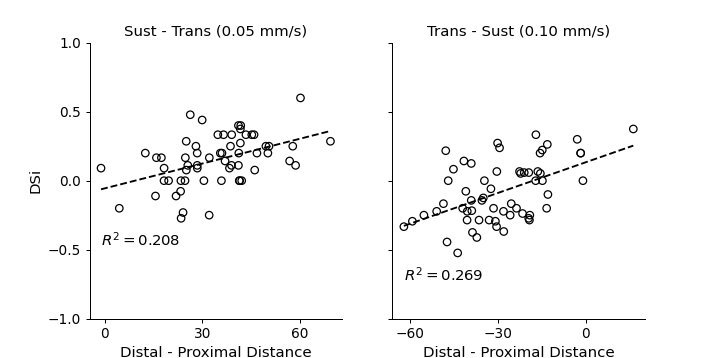

In [13]:
vel_idx = 0
rev_vel_idx = 1

x = bp_means["trans"] - bp_means["sust"]
y = dsis["no_gaba"]["peak_[Ca]"][:, vel_idx]
rev_x = rev_bp_means["trans"] - rev_bp_means["sust"]
rev_y = dsis["no_gaba_rev"]["peak_[Ca]"][:, rev_vel_idx]
fit = stats.linregress(x, y) 
rev_fit = stats.linregress(rev_x, rev_y) 

dsi_vs_distrib_fig, dsi_vs_distrib_ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

dsi_vs_distrib_ax[0].scatter(x, y, facecolors="none", edgecolors="black")
dsi_vs_distrib_ax[0].plot(
    [np.min(x), np.max(x)],
    [fit.intercept + fit.slope*np.min(x), fit.intercept + fit.slope*np.max(x)],
    c="black", linestyle="--"
)
dsi_vs_distrib_ax[0].text(
    np.min(x), np.min(y) - 0.2,
    "$R^2 = %.3f$" % (fit.rvalue ** 2), 
    fontdict={"fontsize": 12},
)
dsi_vs_distrib_ax[1].scatter(rev_x, rev_y, facecolors="none", edgecolors="black")
dsi_vs_distrib_ax[1].plot(
    [np.min(rev_x), np.max(rev_x)],
    [rev_fit.intercept + rev_fit.slope*np.min(rev_x),
     rev_fit.intercept + rev_fit.slope*np.max(rev_x)],
    c="black", linestyle="--"
)
dsi_vs_distrib_ax[1].text(
    np.min(rev_x), np.min(rev_y) - 0.2,
    "$R^2 = %.3f$" % (rev_fit.rvalue ** 2), 
    fontdict={"fontsize": 12},
)

dsi_vs_distrib_ax[0].set_ylabel("DSi", fontsize=12)
dsi_vs_distrib_ax[0].set_ylim(-1, 1)
dsi_vs_distrib_ax[0].set_yticks([-1., -0.5, 0., 0.5, 1.])

dsi_vs_distrib_ax[0].set_title("Sust - Trans (%.2f mm/s)" % velocities[vel_idx])
dsi_vs_distrib_ax[0].set_xlabel("Distal - Proximal Distance", fontsize=12)
dsi_vs_distrib_ax[0].set_xticks([0, 30, 60])

dsi_vs_distrib_ax[1].set_title("Trans - Sust (%.2f mm/s)" % velocities[rev_vel_idx])
dsi_vs_distrib_ax[1].set_xlabel("Distal - Proximal Distance", fontsize=12)
dsi_vs_distrib_ax[1].set_xticks([-60, -30, 0])
clean_axes(dsi_vs_distrib_ax, ticksize=12)

for ext in [".svg", ".png"]:
    dsi_vs_distrib_fig.savefig(
        os.path.join(model_path, "dsi_vs_distrib" + ext), bbox_inches="tight")

## Statisical testing

In [14]:
# one-way ANOVA over bipolar conditions for each velocity
dsi_anovas = [
    stats.f_oneway(*[dsis[c]["peak_[Ca]"][:, v] for c in dsis.keys()])
    for v in range(len(velocities))
]
dsi_st_vs_ts_ttest = [
    stats.ttest_ind(dsis["no_gaba"]["peak_[Ca]"][:, v], dsis["no_gaba_rev"]["peak_[Ca]"][:, v])
    for v in range(len(velocities))
]
dsi_st_vs_alltrans_ttest = [
    stats.ttest_ind(dsis["no_gaba"]["peak_[Ca]"][:, v], dsis["no_gaba_trans"]["peak_[Ca]"][:, v])
    for v in range(len(velocities))
]
dsi_st_vs_allsust_ttest = [
    stats.ttest_ind(dsis["no_gaba"]["peak_[Ca]"][:, v], dsis["no_gaba_sust"]["peak_[Ca]"][:, v])
    for v in range(len(velocities))
]

## Export DSi statistics to CSV

In [15]:
keys_to_col = {
    "no_gaba": "sust-trans",
    "no_gaba_rev": "trans-sust",
    "no_gaba_trans": "all-trans",
    "no_gaba_sust": "all-sust"
}
dsi_mean_df = pd.DataFrame(
    np.array([np.mean(dsis[c]["peak_[Ca]"],axis=0) for c in dsis.keys()]).T,
    columns=[keys_to_col[k] for k in dsis.keys()],
    index=velocities
)
dsi_ste_df = pd.DataFrame(
    np.array([np.std(dsis[c]["peak_[Ca]"],axis=0) / np.sqrt(n_trials) for c in dsis.keys()]).T,
    columns=[keys_to_col[k] for k in dsis.keys()],
    index=velocities
)
dsi_anovas_df = pd.DataFrame(
    np.array([[a.statistic, a.pvalue] for a in dsi_anovas]),
    columns=["F-statistic", "p-value"],
    index=velocities
)
dsi_st_vs_ts_ttest_df = pd.DataFrame(
    np.array([[a.statistic, a.pvalue] for a in dsi_st_vs_ts_ttest]),
    columns=["t-statistic", "p-value"],
    index=velocities
)
dsi_st_vs_alltrans_ttest_df = pd.DataFrame(
    np.array([[a.statistic, a.pvalue] for a in dsi_st_vs_alltrans_ttest]),
    columns=["t-statistic", "p-value"],
    index=velocities
)
dsi_st_vs_allsust_ttest_df = pd.DataFrame(
    np.array([[a.statistic, a.pvalue] for a in dsi_st_vs_allsust_ttest]),
    columns=["t-statistic", "p-value"],
    index=velocities
)

dsi_mean_df.to_csv(os.path.join(model_path, "dsi_mean.csv"), index_label="velocity")
dsi_ste_df.to_csv(os.path.join(model_path, "dsi_standard_error.csv"), index_label="velocity")
dsi_anovas_df.to_csv(os.path.join(model_path, "dsi_anovas.csv"), index_label="velocity")
dsi_st_vs_ts_ttest_df.to_csv(os.path.join(model_path, "dsi_st_vs_ts_ttest.csv"), index_label="velocity")
dsi_st_vs_alltrans_ttest_df.to_csv(os.path.join(model_path, "dsi_st_vs_alltrans_ttest.csv"), index_label="velocity")
dsi_st_vs_allsust_ttest_df.to_csv(os.path.join(model_path, "dsi_st_vs_allsust_ttest.csv"), index_label="velocity")

In [19]:
dsi_anovas_df

,F-statistic,p-value
0.05,15.856060,1.999497e-09
0.10,28.524316,8.951253e-16
0.15,42.894369,3.668210e-22
0.20,27.377523,3.138591e-15
0.25,24.682692,6.302431e-14
0.50,17.409232,3.031665e-10
0.75,6.626010,2.575771e-04
1.00,3.252656,2.247705e-02
1.25,1.857747,1.374427e-01
1.50,8.796711,1.493891e-05


In [16]:
dsi_st_vs_ts_ttest_df

,t-statistic,p-value
0.05,5.875873,3.979625e-08
0.10,8.258998,2.442404e-13
0.15,9.782582,6.574668e-17
0.20,8.455124,8.600662e-14
0.25,7.563577,9.383309e-12
0.50,6.150956,1.085796e-08
0.75,2.946201,3.877133e-03
1.00,-0.089930,9.284951e-01
1.25,-0.526485,5.995395e-01
1.50,-4.635195,9.271755e-06


In [17]:
dsi_st_vs_alltrans_ttest_df

,t-statistic,p-value
0.05,1.623273,0.107200
0.10,4.349986,0.000029
0.15,3.354040,0.001071
0.20,2.238338,0.027075
0.25,2.469515,0.014961
0.50,2.036084,0.043981
0.75,-0.693275,0.489499
1.00,-1.379834,0.170247
1.25,-2.138603,0.034529
1.50,-0.200864,0.841151


In [18]:
dsi_st_vs_allsust_ttest_df

,t-statistic,p-value
0.05,3.693572,3.364499e-04
0.10,5.923932,3.178315e-08
0.15,7.553216,9.900412e-12
0.20,5.806713,5.491166e-08
0.25,5.246302,6.923081e-07
0.50,3.872027,1.775640e-04
0.75,-0.391412,6.961983e-01
1.00,2.077246,3.994867e-02
1.25,-1.844775,6.757795e-02
1.50,-1.248683,2.142526e-01
